# Предсказание успешности стартапов.

**Описание исходных данных:**

Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать.

Столбцы датасета:
- name - Название стартапа
- category_list - Список категорий, к которым относится стартап
- funding_total_usd - Общая сумма финансирования в USD
- <span style="color: orange;">status - Статус стартапа (закрыт или действующий) - Целевой признак</span>
- country_code - Код страны
- state_code - Код штата
- region - Регион
- city - Город
- funding_rounds - Количество раундов финансирования
- founded_at - Дата основания
- first_funding_at - Дата первого раунда финансирования
- last_funding_at - Дата последнего раунда финансирования
- closed_at - Дата закрытия стартапа (если применимо)


# Загрузка и обзор данных

## Импорты

In [11]:
import pandas as pd
import numpy as np
import skimpy

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

from pycaret.classification import *

import chime
chime.theme('mario')
%load_ext chime

The chime extension is already loaded. To reload it, use:
  %reload_ext chime


## Загрузка данных

In [12]:
date_columns = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
df = pd.read_csv('kaggle_startups_train_01.csv', parse_dates=date_columns)

df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaT


In [13]:
target = 'status'
target_values = df[target].unique()
target_values

array(['operating', 'closed'], dtype=object)

## Обзор данных

### skimpy и info

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52879 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52878 non-null  object        
 1   category_list      50374 non-null  object        
 2   funding_total_usd  42753 non-null  float64       
 3   status             52879 non-null  object        
 4   country_code       47351 non-null  object        
 5   state_code         46082 non-null  object        
 6   region             46489 non-null  object        
 7   city               46489 non-null  object        
 8   funding_rounds     52879 non-null  int64         
 9   founded_at         52879 non-null  datetime64[ns]
 10  first_funding_at   52858 non-null  datetime64[ns]
 11  last_funding_at    52879 non-null  datetime64[ns]
 12  closed_at          4962 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [15]:
(df[target] == 'closed').sum() == (~df['closed_at'].isna()*1).sum()

True

In [16]:
skimpy.skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 52879  │ │ string      │ 7     │                                                          │
│ │ Number of columns │ 13     │ │ datetime64  │ 4     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                │ int32       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_nam ┃       ┃       ┃          ┃           ┃    ┃        ┃         ┃          ┃            ┃        ┃  │
│ ┃ e          ┃ NA    ┃ NA %  ┃ mean     ┃ sd        ┃ p0 ┃ p25    ┃ p50     ┃ p75      ┃ p100       ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ funding_to │ 10126 │ 19.15 │ 19000000 │ 210000000 │  1 │ 340000 │ 2000000 │ 10000000 │ 3000000000 │   ▇    │  │
│ │ tal_usd    │       │       │          │           │    │        │         │          │          0 │        │  │
│ │ funding_ro │     0 │     0 │      1.7 │       1.4 │  1 │      1 │       1 │        2 │         19 │   ▇▁   │  │
│ │ unds       │       │       │          │           │    │        │         │          │            │        │  │
│ └────────────┴───────┴───────┴──────────┴───────────┴────┴────────┴─────────┴──────────┴────────────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                ┃ NA        ┃ NA %      ┃ first             ┃ last             ┃ frequency      ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩  │
│ │ founded_at                 │         0 │         0 │    1749-01-01     │    2105-02-17    │ None           │  │
│ │ first_funding_at           │        21 │      0.04 │    1960-01-01     │    2015-12-05    │ None           │  │
│ │ last_funding_at            │         0 │         0 │    1971-01-01     │    2115-12-01    │ None           │  │
│ │ closed_at                  │     47917 │     90.62 │    1972-09-06     │    2106-07-20    │ None           │  │
│ └────────────────────────────┴───────────┴───────────┴───────────────────┴──────────────────┴────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                ┃ NA         ┃ NA %        ┃ words per row              ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ name                       │          1 │           0 │                        1.6 │                 85317 │  │
│ │ category_list              │       2505 │        4.7

Промежуточные выводы первичного обзора:
- **1.** Имеются во всех колонках кроме <span style="color: orange;">status (целевой признак), last_funding_at (последняя дата финансирования) и founded_at (дата основания)</span>, в колонке name только 1 пропуск.
- **2.** В <span style="color: orange;">closed_at</span>  90.62 % пропусков столько же солько и закрытых стартапов - если стартап функционируют, то будет стоять пропуск. При обучении модели этот признак нужно будет удалить.
- **3.** В остальных колонках пропуски составляют от 4.74 до 19.15 %, причём к признаках с информацией об регионе-городе-области количество пропусков схоже, в признаках страны немного меньше пропусков.
- **4** В признаках <span style="color: orange;">founded_at, last_funding_at и closed_at</span> есть странные последние даты 2105-02-17, 2115-12-01, 2106-07-20. Вероятно такие случаи являются опечатками и нужно просто вычесть 100 лет из дат относящихся к 22-му веку. 
- **5.** В колонке <span style="color: orange;">founded_at</span> есть странная дата "1749-01-01", это может сотвествовать дате основания какой-нибудь крупной компании, но не похоже на стратап. Полазив в поиске нашёл только пивоваренную компанию Scottish & Newcastle, которая с 25 января 2008 года была приобретена компаниями Carlsberg и Heineken. Посмотрю потом в данных, может это про неё. :)
- **6.** В числовом признаке <span style="color: orange;">funding_total_usd</span> (общая сумма финансирования) есть 19.15% пропусков, нужно будет изучить с чем это может быть связано и найти оптимальный способ восполнения. На этот признак я обращу особое внимание, потому что он может иметь большое значение для предсказания модели. Возможно потребуется создать категориальный столбец funding_total_usd_is_not_na указав под 0 там где был пропуск и 1 там где нет.

## EDA - Визуализация и первичная предобработка.

### Числовые признаки

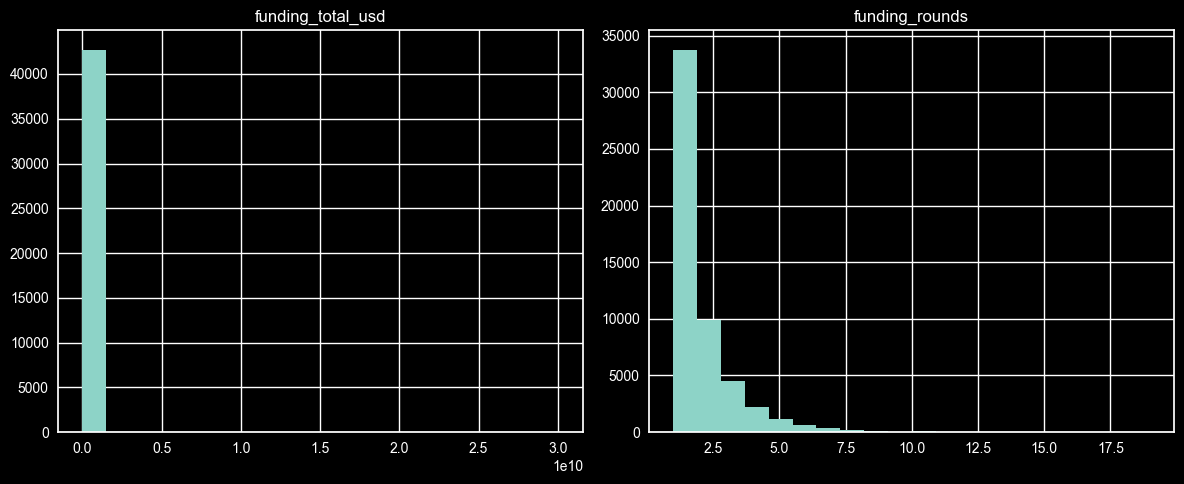

In [17]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

df[numeric_columns].hist(bins=20, figsize=(12, 5))
plt.tight_layout()
plt.show()

Видно жирнохвостовое распределение в обоих признаках. Оба графика пока соотвествуют здравому смыслу.
- **Размер финансирования** - находится в пределах 3 млрд. USD, сумма большая, но вполне реальная. Медийное значение - 2 млн. USD, среднее - 19 млн. USD
- **Количество раундов финансирования** максимально значение 19 раундов является вполне возможным. Медийное значение - 1 раунд, среднее - 1.7.

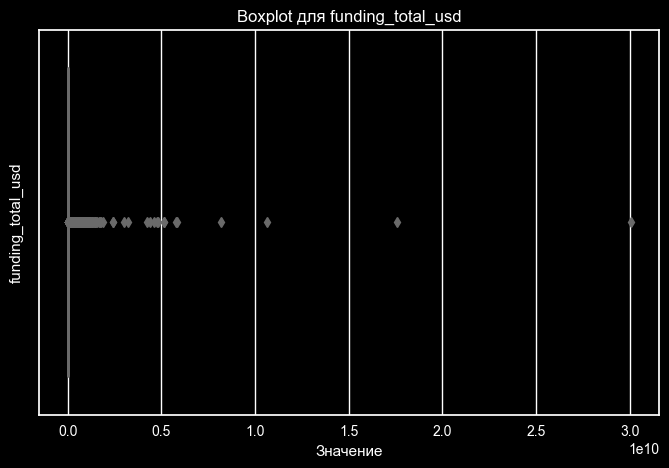

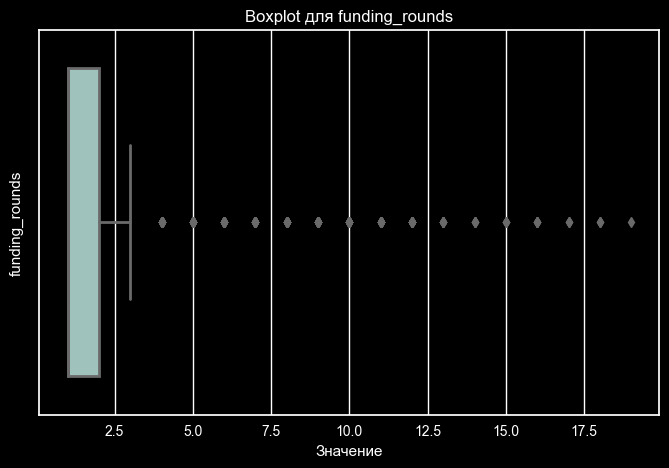

In [18]:
for column in numeric_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[column], orient='h', linewidth=2, saturation=0.5)
    plt.title(f'Boxplot для {column}')
    plt.xlabel('Значение')
    plt.ylabel(column)
    plt.show()

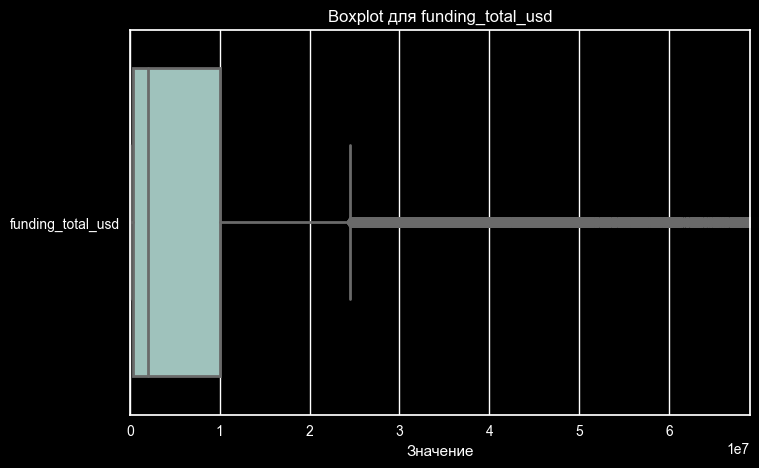

In [19]:
usd_col = numeric_columns[0]
plt.figure(figsize=(8, 5))
sns.boxplot(df[[usd_col]], orient='h', linewidth=2, saturation=0.5)
plt.title(f'Boxplot для {usd_col}')
plt.xlim(0,df[usd_col].quantile(0.95))
plt.xlabel('Значение')
plt.show()

Большинство значений общей суммы финансировнаия от 340 тыс. до 10 млн. USD.
Большинство стартапов имеют 1,2 раунда финансирования

Боксплот так же говорит о большом разбросе в числовых данных. При обучении моделей определённо нужно будет задействовать scaler.

In [20]:
rounds_group = (df[numeric_columns]
                .groupby(['funding_rounds'])['funding_total_usd']
                .agg(['mean','median','max','min','count']))
rounds_group

,mean,median,max,min,count
funding_rounds,,,,,
1,1.043620e+07,889386.0,1.760000e+10,1.000000e+00,24525
2,1.394991e+07,2954737.0,5.162513e+09,6.800000e+01,9156
3,2.266435e+07,7273407.0,4.240250e+09,5.000000e+03,4349
4,3.433287e+07,15000000.0,1.159803e+09,1.393300e+04,2161
5,7.680646e+07,25541542.0,3.007950e+10,9.000000e+04,1165
6,8.467591e+07,35886875.0,5.820000e+09,2.133000e+04,615
7,1.035474e+08,46670000.0,4.812000e+09,1.450000e+05,339
8,1.239461e+08,67438045.5,1.567504e+09,6.669530e+05,174
9,1.341547e+08,61600000.0,1.471000e+09,6.000000e+05,108


<Axes: xlabel='funding_rounds'>

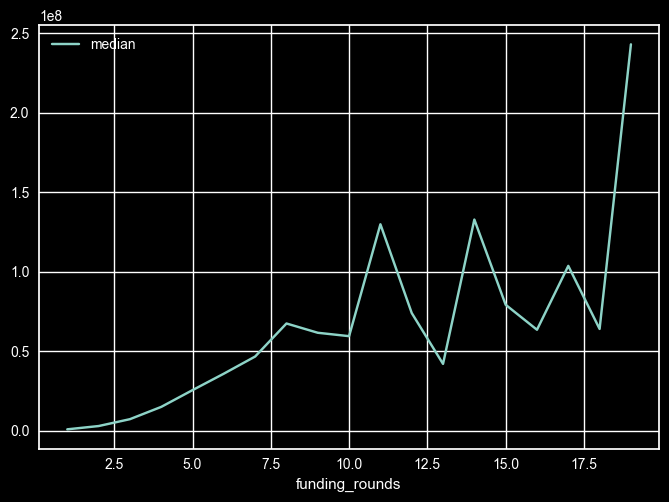

In [21]:
rounds_group[['median']].plot()

In [22]:
df[list(numeric_columns)+[target]]

,funding_total_usd,funding_rounds,status
0,828626.0,2,operating
1,42935019.0,4,operating
2,35456381.0,3,operating
3,22250000.0,3,operating
4,NaN,1,operating
...,...,...,...
52874,NaN,1,operating
52875,500000.0,1,operating
52876,50000.0,3,operating
52877,13000000.0,6,operating


In [23]:
def groupby_target(df,cols_list,target='status',
                   group_cols=[],display_cols='funding_total_usd',
                   agg=['mean','median','max','min','count']):
    '''Функкция принимает на вход датафрейм, список колонок и название целевого признака'''
    return (df[cols_list+[target]]
                .groupby(group_cols)[display_cols]
                .agg(agg))

In [24]:
rounds_status_group = groupby_target(df,list(numeric_columns),group_cols=['funding_rounds']+[target])
rounds_status_group

mean       median           max  \
funding_rounds status                                               
1              closed     7.366714e+06     800000.0  9.150000e+08   
               operating  1.083612e+07     900000.0  1.760000e+10   
2              closed     1.387500e+07    2610000.0  8.705790e+08   
               operating  1.395601e+07    2999969.0  5.162513e+09   
3              closed     2.021492e+07    8592229.5  1.587000e+08   
               operating  2.279112e+07    7175000.0  4.240250e+09   
4              closed     3.387087e+07   23000000.0  3.740000e+08   
               operating  3.435458e+07   14536250.0  1.159803e+09   
5              closed     3.768301e+07   36069167.0  1.563045e+08   
               operating  7.834208e+07   25523512.0  3.007950e+10   
6              closed     4.931489e+07   22469238.5  3.658730e+08   
               operating  8.611189e+07   36962500.0  5.820000e+09   
7              closed     3.740508e+07   23138876.0  1.300035e+08   
               operating  1.053513e+08   47999920.5  4.812000e+09   
8              closed     1.871927e+08   36004847.0  1.567504e+09   
               operating  1.188392e+08   67576091.0  1.185585e+09   
9              closed     5.575902e+07   11554116.5  1.966641e+08   
               operating  1.371699e+08   63697590.5  1.471000e+09   
10             closed     5.946364e+07   59463635.0  5.946364e+07   
               operating  1.332895e+08   59723603.0  1.315500e+09   
11             closed     5.895340e+07   58953398.5  1.165680e+08   
               operating  3.446059e+08  131585890.5  2.425700e+09   
12             operating  1.277473e+08   74016526.5  8.188000e+08   
13             operating  9.950292e+08   42027500.0  8.207450e+09   
14             operating  3.768629e+08  132787385.0  1.158040e+09   
15             operating  8.006212e+07   79209599.0  2.048921e+08   
16             operating  3.203274e+08   63505195.0  1.671557e+09   
17             operating  1.326086e+08  103662749.0  2.475458e+08   
18             operating  8.069141e+07   63997160.0  1.388451e+08   
19             operating  2.429488e+08  242948825.0  2.429488e+08   

                                   min  count  
funding_rounds status                          
1              closed     2.000000e+00   2827  
               operating  1.000000e+00  21698  
2              closed     4.500000e+03    689  
               operating  6.800000e+01   8467  
3              closed     3.000000e+04    214  
               operating  5.000000e+03   4135  
4              closed     4.350000e+05     97  
               operating  1.393300e+04   2064  
5              closed     1.200000e+06     44  
               operating  9.000000e+04   1121  
6              closed     8.670000e+05     24  
               operating  2.133000e+04    591  
7              closed     4.572820e+05      9  
               operating  1.450000e+05    330  
8              closed     1.455000e+06     13  
               operating  6.669530e+05    161  
9              closed     3.263734e+06      4  
               operating  6.000000e+05    104  
10             closed     5.946364e+07      1  
               operating  1.664000e+06     60  
11             closed     1.338750e+06      2  
               operating  5.650000e+06     44  
12             operating  1.507200e+06     22  
13             operating  6.280622e+06      9  
14             operating  9.050000e+06      5  
15             operating  1.203266e+07      5  
16             operating  4.845320e+06      6  
17             operating  4.661711e+07      3  
18             operating  3.923199e+07      3  
19             operating  2.429488e+08      1

После 6го раунда финансирования количество закрытых стартапов стремиться к 0.

In [25]:
con_data = None
for t in target_values:
    d = (rounds_status_group.reset_index().set_index('funding_rounds')
     .query(f"{target} == '{t}'")[['median','count']])
    if con_data is None:
        con_data = d
        ft = f'_{t}'
    else:
        con_data = pd.merge(con_data,d,how='left',left_index=True,right_index=True,
                            suffixes=(ft, f'_{t}')).fillna(0)
con_data

,median_operating,count_operating,median_closed,count_closed
funding_rounds,,,,
1,900000.0,21698,800000.0,2827.0
2,2999969.0,8467,2610000.0,689.0
3,7175000.0,4135,8592229.5,214.0
4,14536250.0,2064,23000000.0,97.0
5,25523512.0,1121,36069167.0,44.0
6,36962500.0,591,22469238.5,24.0
7,47999920.5,330,23138876.0,9.0
8,67576091.0,161,36004847.0,13.0
9,63697590.5,104,11554116.5,4.0


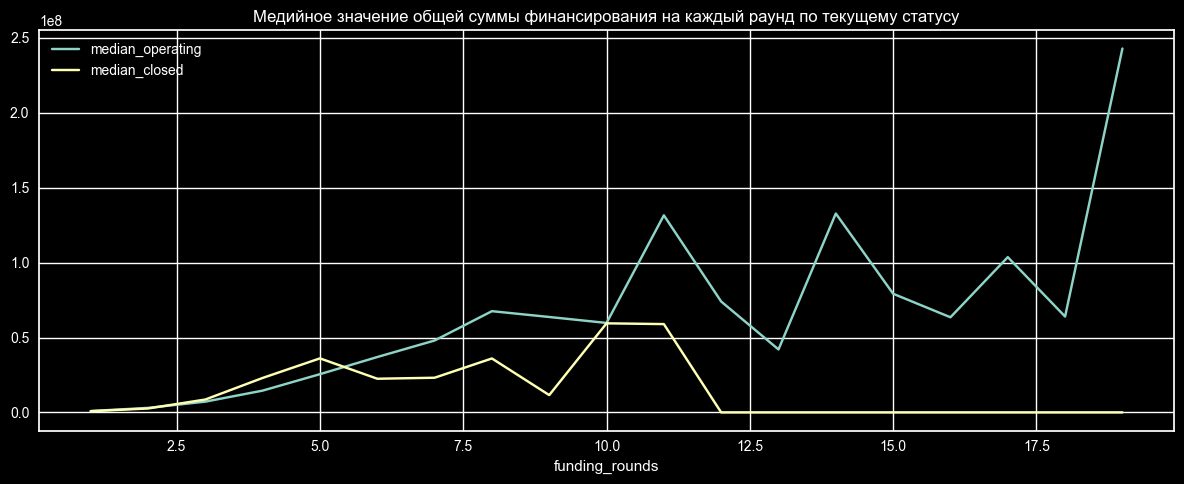

In [26]:
medians = ['median_' + v for v in target_values]
con_data[medians].plot(figsize=(12,5))
plt.title('Медийное значение общей суммы финансирования на каждый раунд по текущему статусу')
plt.tight_layout()
plt.show()

Общая сумма финансирования растёт с каждым раундом у рабочих проектов и перестаёт расти после 5го раунда у закрытых проектов.

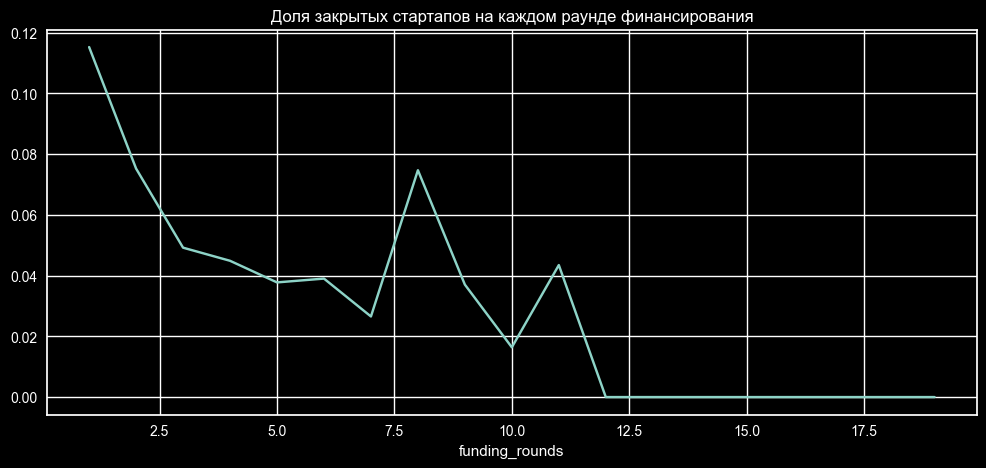

,median_operating,count_operating,median_closed,count_closed,closed_fraction
funding_rounds,,,,,
1,900000.0,21698,800000.0,2827.0,0.115270
2,2999969.0,8467,2610000.0,689.0,0.075251
3,7175000.0,4135,8592229.5,214.0,0.049207
4,14536250.0,2064,23000000.0,97.0,0.044887
5,25523512.0,1121,36069167.0,44.0,0.037768
6,36962500.0,591,22469238.5,24.0,0.039024
7,47999920.5,330,23138876.0,9.0,0.026549
8,67576091.0,161,36004847.0,13.0,0.074713
9,63697590.5,104,11554116.5,4.0,0.037037


In [27]:
sum_data = None
for t in target_values:
    if sum_data is None:
        sum_data = con_data[f'count_{t}']
    else:
        sum_data = sum_data+con_data[f'count_{t}']
con_data['closed_fraction'] = con_data['count_closed'] / sum_data

con_data['closed_fraction'].plot(figsize=(12,5))
plt.title('Доля закрытых стартапов на каждом раунде финансирования')
plt.show()
con_data

Доля закрытых стартапов падает с количеством раундов финансирования, максимум закрытых стартапов после самого первого раунда - 11.5%.

#### Промежуточные выводы.

- **Этот признак является важным для обучения модели.**
- Доля закрытых стартапов падает с количеством раундов финансирования, максимум закрытых стартапов после самого первого раунда - 11.5%.
- Общая сумма финансирования растёт с каждым раундом у рабочих проектов и перестаёт расти после 5го раунда у закрытых проектов.
- После 6го раунда финансирования количество закрытых стартапов стремиться к 0.
- Размер финансирования - находится в пределах 3 млрд. USD, сумма большая, но вполне реальная. Медийное значение - 2 млн. USD, среднее - 19 млн. USD
- Количество раундов финансирования максимально значение 19 раундов является вполне возможным. Медийное значение - 1 раунд, среднее - 1.7.
- Большинство значений общей суммы финансировнаия от 340 тыс. до 10 млн. USD.
- Большинство стартапов имеют 1,2 раунда финансирования
- Боксплот так же говорит о большом разбросе в числовых данных. При обучении моделей определённо нужно будет задействовать scaler.

### Категориальные признаки

#### Список категорий

Предобработаю список категорий для возможности интерпритации.

Перевожу формат из текста в лист с использованием разделителей | и +.

In [28]:
df['category_list'] = (df['category_list'].fillna('unknown'))
df.sample(5)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
38359,Kokoon technology,unknown,NaN,operating,NaN,NaN,NaN,NaN,1,2013-10-21,2015-01-02,2015-01-02,NaT
24943,LiquidSky Software,Software,1329500.0,operating,USA,NY,New York City,Tarrytown,1,2014-12-12,2015-07-02,2015-07-02,NaT
50689,AKSEL GROUP,E-Commerce|Fashion|Lifestyle|Shopping,500000.0,operating,USA,NY,New York City,New York,1,2010-01-01,2011-11-07,2011-11-07,NaT
45258,Villas at Oak Grove,Home & Garden|Real Estate|Search,25000.0,operating,USA,FL,Tallahassee,Tallahassee,1,2011-06-06,2012-04-06,2012-04-06,NaT
1158,Pixie Technology,Internet of Things|Software,6000000.0,operating,USA,CA,SF Bay Area,Los Altos,2,2011-01-01,2013-12-10,2014-03-01,NaT


Применяю One-Hot Encoding к колонке "category_list" для исследования данных. Заменять колокни в датасете не буду, потому что OHE будет использоваться в pipline при обучении модели.

In [29]:
df['category_list']

0               Online Reservations|Restaurants
1         Manufacturing|Medical|Medical Devices
2                                 Biotechnology
3                                   Health Care
4                                 Manufacturing
                          ...                  
52874                             Entertainment
52875                               Hospitality
52876     Email|Messaging|Productivity Software
52877                                  Security
52878    Online Rental|Parking|Price Comparison
Name: category_list, Length: 52879, dtype: object

In [30]:
category_dummies = df['category_list'].str.get_dummies()

In [31]:
print(f' Количество категорий: {category_dummies.shape[1]}')

 Количество категорий: 855


In [32]:
n = 20
print(f'Топ-{n} категорий')
top = pd.DataFrame(category_dummies.sum().sort_values(ascending=0).head(n),
             columns=['Количество стартапов'])
bottom = pd.DataFrame(category_dummies.sum().sort_values(ascending=1).head(n),
             columns=['Количество стартапов'])
display(top)
print(f'Нижние-{n} категорий')
display(bottom)

Топ-20 категорий


,Количество стартапов
Software,7033
Mobile,4405
Biotechnology,3683
E-Commerce,3316
unknown,2505
Curated Web,2417
Social Media,2287
Enterprise Software,2197
Advertising,1993
Health Care,1895


Нижние-20 категорий


,Количество стартапов
Labor Optimization,1
Baby Boomers,1
Private Corrections,1
Fuel Cells,1
Elderly,1
Sex Industry,1
Biotechnology and Semiconductor,1
Vulnerability Management,1
Early Stage IT,1
EDA Tools,1


In [33]:
df.iloc[category_dummies[category_dummies["Sex Industry"] == 1].index]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
22071,Pornhub,Sex Industry|SexTech,4299.0,operating,BLZ,1,Belize,Belize City,1,2014-11-16,2015-06-10,2015-06-10,NaT


Ну да, кто бы сомневался )

In [34]:
category_dummies.sum()[category_dummies.sum()==1].count()

24

24 категории встречаются в датасете единожды, для обучения модели они не будут иметь ценности, нужно будет учесть это при обработке OHE или OE.

In [35]:
category_dummies = category_dummies.merge((df[target] == target_values[1]) *1,
                                           left_index=True, right_index=True)

In [36]:
top_category_status = None
for col in top.index[:]:
    d = pd.DataFrame({'Категория':[col],
        'Доля закрытых стратапов': [category_dummies[category_dummies[col]==1][target].mean()],
        'Количество в датасете': [category_dummies[category_dummies[col]==1][target].count()]})
    if top_category_status is not None:
        top_category_status = pd.concat([top_category_status,d])
    else:
        top_category_status = pd.concat([top_category_status,d])
top_category_status.sort_values('Доля закрытых стратапов',ascending=0).reset_index(drop=1)

,Категория,Доля закрытых стратапов,Количество в датасете
0,unknown,0.293812,2505
1,Curated Web,0.174183,2417
2,Social Media,0.127678,2287
3,Games,0.115406,1811
4,Internet,0.111111,1665
5,Advertising,0.095334,1993
6,Apps,0.090599,1468
7,Mobile,0.089898,4405
8,Clean Technology,0.085297,1231
9,E-Commerce,0.082328,3316


Как видно по топ-20 самых популярных категорий, этот признак влияет на успешность стартапа. К примеру категория Curated Web имеет 17.4% закрытых стартапов, а категория Health and Wellness всего 4%.

Теперь изчу самые успешные и неуспешные категории по всему датасету, исключу категории которые занимают менее 0.1% данных.

In [37]:
round(df.shape[0]*0.001)

53

In [38]:
good_catagory_cols = (category_dummies.drop(columns=target).sum()
                      [(category_dummies.sum() > round(df.shape[0]*0.001)) == True].index)

In [39]:
n = 20
category_status = None
for col in good_catagory_cols:
    d = pd.DataFrame({'Категория':[col],
        'Доля закрытых стратапов': [category_dummies[category_dummies[col]==1][target].mean()],
        'Количество в датасете': [category_dummies[category_dummies[col]==1][target].count()]})
    if category_status is not None:
        category_status = pd.concat([category_status,d])
    else:
        category_status = pd.concat([category_status,d])
# category_status.sort_values('Доля закрытых стратапов',ascending=0).reset_index(drop=1)

print(f'Топ-{n} самых успешных категорий')
display(category_status.sort_values('Доля закрытых стратапов').reset_index(drop=1).head(n))
print(f'Топ-{n} самых неудачных категорий')
category_status.sort_values('Доля закрытых стратапов',ascending=0).reset_index(drop=1).head(n)

Топ-20 самых успешных категорий


,Категория,Доля закрытых стратапов,Количество в датасете
0,Business Analytics,0.000000,67
1,K-12 Education,0.000000,65
2,Mobile Health,0.009434,106
3,Home Automation,0.009804,102
4,Sales Automation,0.015152,66
5,Energy Management,0.015625,64
6,IT Management,0.016667,60
7,Agriculture,0.017699,113
8,Mobile Software Tools,0.017857,112
9,Computer Vision,0.018182,55


Топ-20 самых неудачных категорий


,Категория,Доля закрытых стратапов,Количество в датасете
0,unknown,0.293812,2505
1,Coupons,0.250000,124
2,Systems,0.240741,54
3,Social Buying,0.218182,55
4,Services,0.201049,1144
5,Portals,0.196429,56
6,Promotional,0.186667,75
7,VoIP,0.180851,94
8,Application Platforms,0.178744,207
9,Local Search,0.175676,74


##### Промежуточные вывод

Как видно разброс достаточно большой, в некторых категория все стартапы успешные, а в некоторых и 25% провальные.
- Среди топ-20 самых успешных категорий находятся много IT направлений,в том числе Big Data, CV и автоматизация. Доля закрытых стартапов от 0 до 2.7 %
- Среди топ-20 самых провальных категорий доля закрытых стартапов от 16 до 25 %
- Среди стартапов с неуказанной категорией доля закрытых самая большая и составляет 29.4%
- **Этот признак определённо является важным для определения успешности стартапа**

#### Страна, штат, регион, город

In [40]:
categorical_columns = ['country_code', 'state_code', 'region','city']

Обработаю пропуски для более точного анализа.

In [41]:
df[categorical_columns] = df[categorical_columns].fillna('unknown')

In [42]:
print('Количество уникальных значений для каждого признака:')
for column in categorical_columns:
    print(column,': ',df[column].unique().shape[0])

Количество уникальных значений для каждого признака:
country_code :  135
state_code :  301
region :  1038
city :  4525


In [43]:
print('Количество значений, которые встречаються только 1 раз')
for column in categorical_columns[:]:
    print(column,': ',(df[column].value_counts() == 1).sum())

Количество значений, которые встречаються только 1 раз
country_code :  22
state_code :  44
region :  220
city :  2332


In [44]:
print('Количество значений, которые встречаються 5 раз или реже')
for column in categorical_columns[:]:
    print(column,': ',(df[column].value_counts() <= 5).sum())

Количество значений, которые встречаються 5 раз или реже
country_code :  54
state_code :  109
region :  584
city :  3680


Есть очень много значений, которые встречаются лишь единожды и очевидно, что они не несут ценности для обучения модели, во времи предобработки с помощью OHE нужно будут указать, чтобы такие значения пропускались, это позволит значительно ускорить процес обучения и предсказания модели. А так же стоит рассмотреть вариант урезать ещё сильнее и в OHE отфлитровать значения которые встречаются 5 раз или реже.

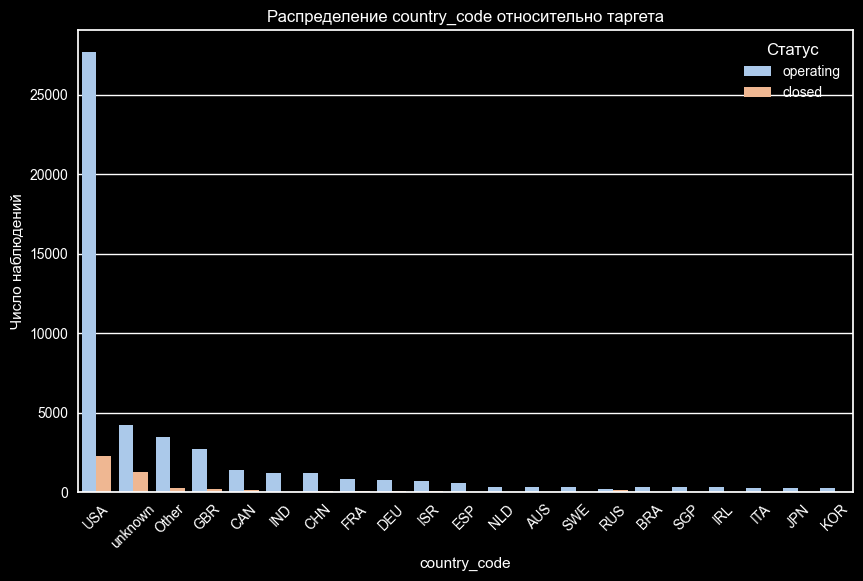

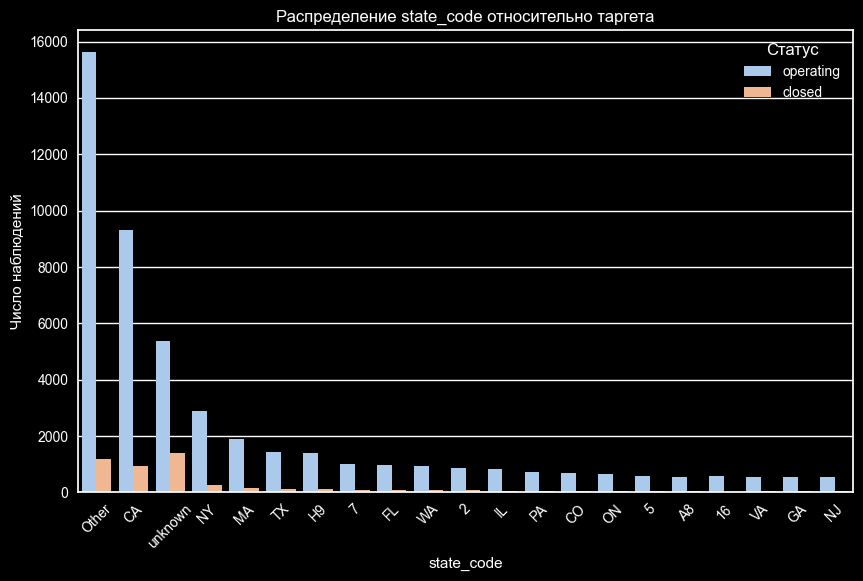

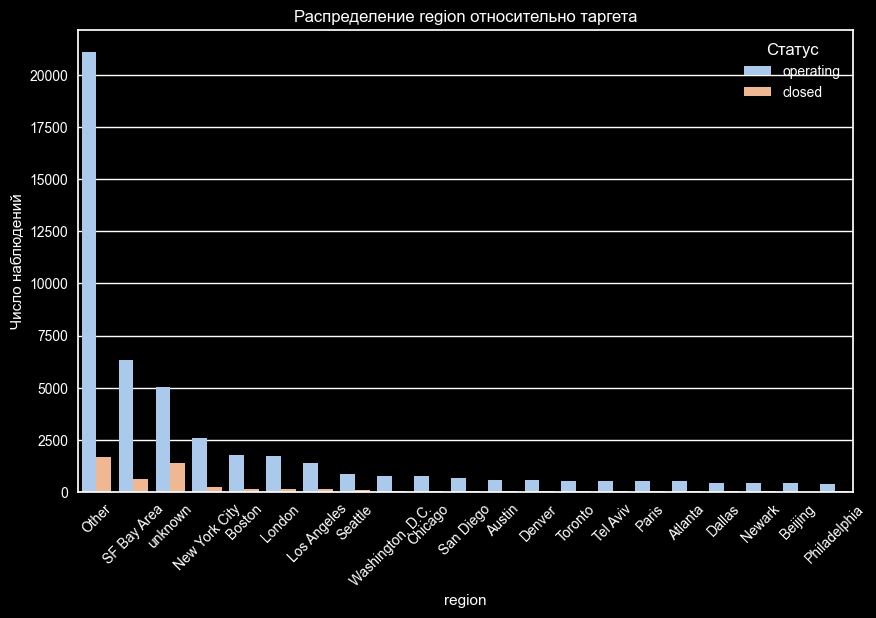

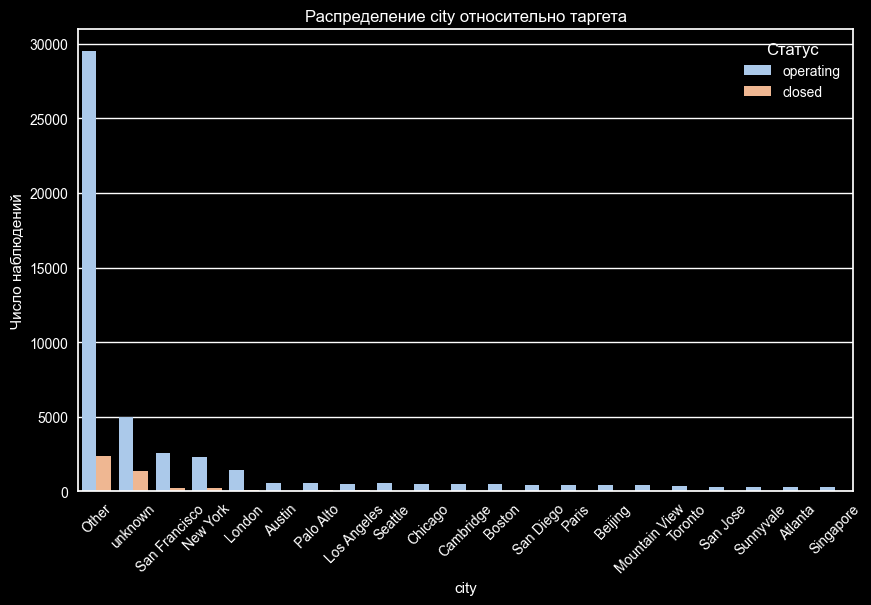

In [45]:
top_n = 20

def group_categories(df,column, top_n):
    top_categories = df[column].value_counts().head(top_n).index
    df[column] = df[column].apply(lambda x: x if x in top_categories else 'Other')
    return df

geo_df = df.copy()
for column in categorical_columns:
    geo_df = group_categories(geo_df,column, top_n)

for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    order = geo_df[column].value_counts().index
    sns.countplot(data=geo_df, x=column, hue='status', palette='pastel', order=order)
    plt.title(f'Распределение {column} относительно таргета')
    plt.xlabel(column)
    plt.ylabel('Число наблюдений')
    plt.xticks(rotation=45)
    plt.legend(title='Статус', loc='upper right')
    plt.show()

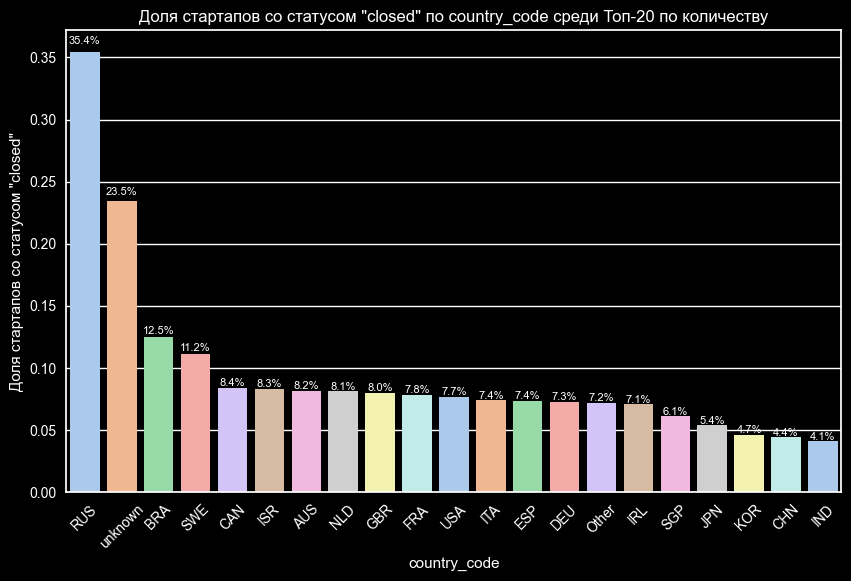

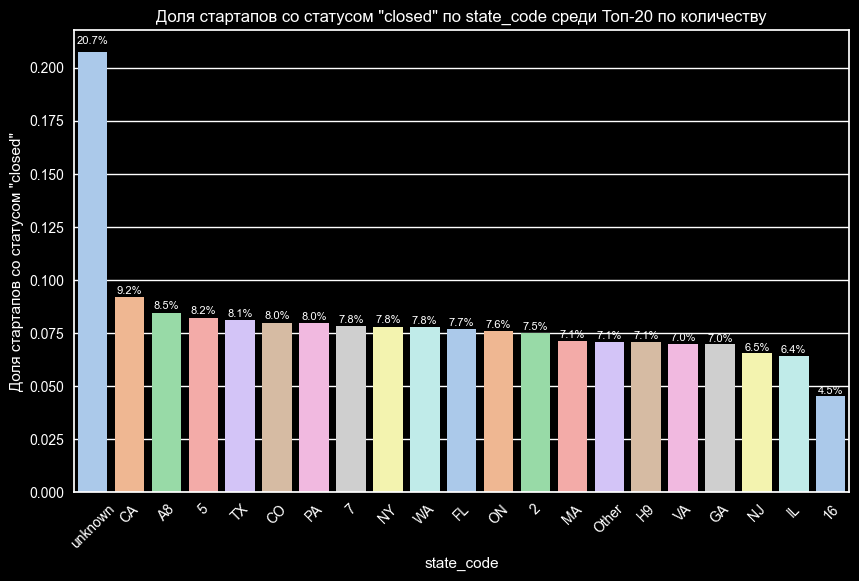

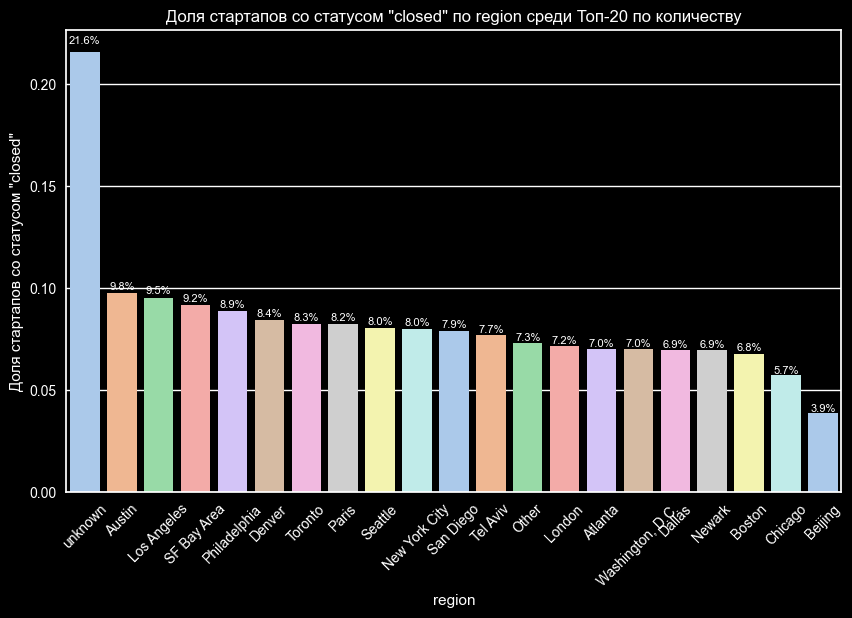

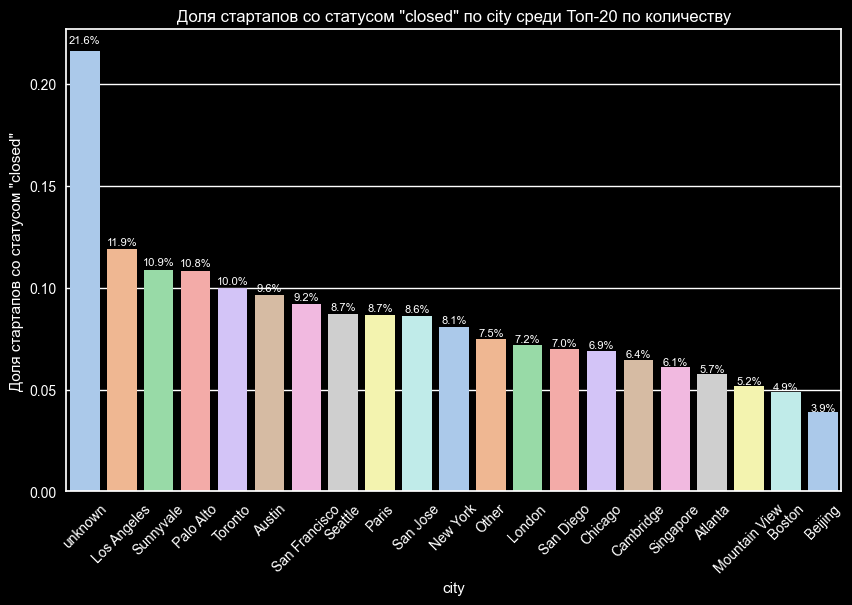

In [46]:
def plot_closed_ratio(df, column, top_n):
    # Объединяем редкие категории в одну общую категорию "Other"
    top_categories = df[column].value_counts().head(top_n).index
    df[column] = df[column].apply(lambda x: x if x in top_categories else 'Other')
    
    # Вычисляем долю стартапов со статусом 'closed' для каждой категории
    closed_ratio = df.groupby(column)['status'].apply(lambda x: (x == 'closed').mean()).reset_index(name='closed_ratio')

    # Сортируем значения по убыванию доли стартапов со статусом 'closed'
    closed_ratio = closed_ratio.sort_values(by='closed_ratio', ascending=False)

    # Построение графика
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=closed_ratio, x=column, y='closed_ratio', palette='pastel')
    plt.title(f'Доля стартапов cо статусом "closed" по {column} среди Топ-{top_n} по количеству')
    plt.xlabel(column)
    plt.ylabel('Доля стартапов со статусом "closed"')
    plt.xticks(rotation=45)

    # Добавляем подписи процента закрытых стартапов над барами
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.02*height, f'{height * 100:.1f}%', ha='center',fontsize=8)

    plt.show()

# Задаем количество топ N категорий, которые будем отображать
top_n = 20

# Построение графиков для категориальных признаков
for column in categorical_columns:
    plot_closed_ratio(df.copy(), column, top_n)

In [47]:
df.query('country_code == "RUS"').shape[0]

370

Расмотрим подробнее Россию


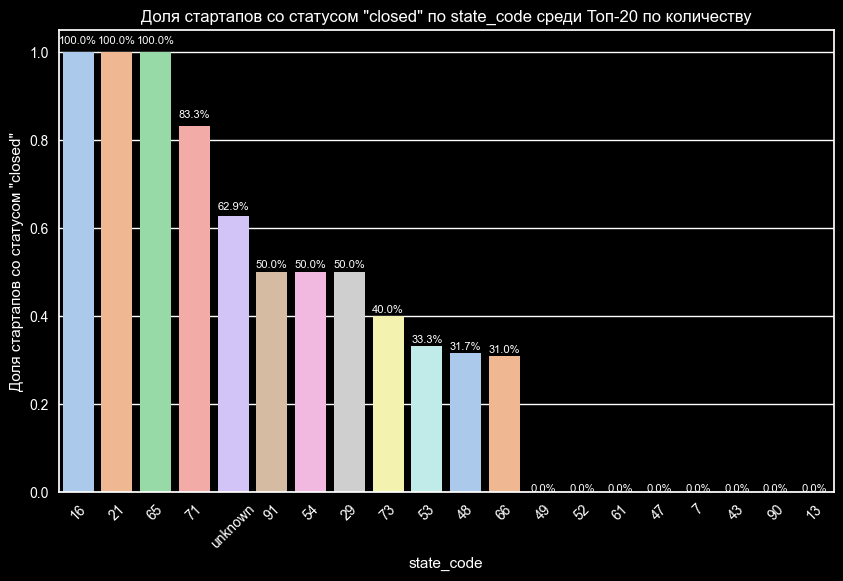

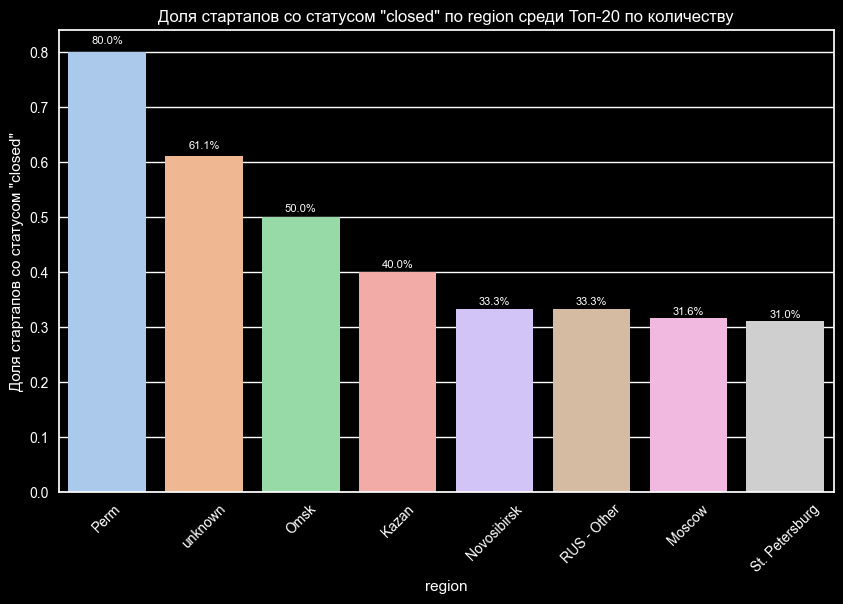

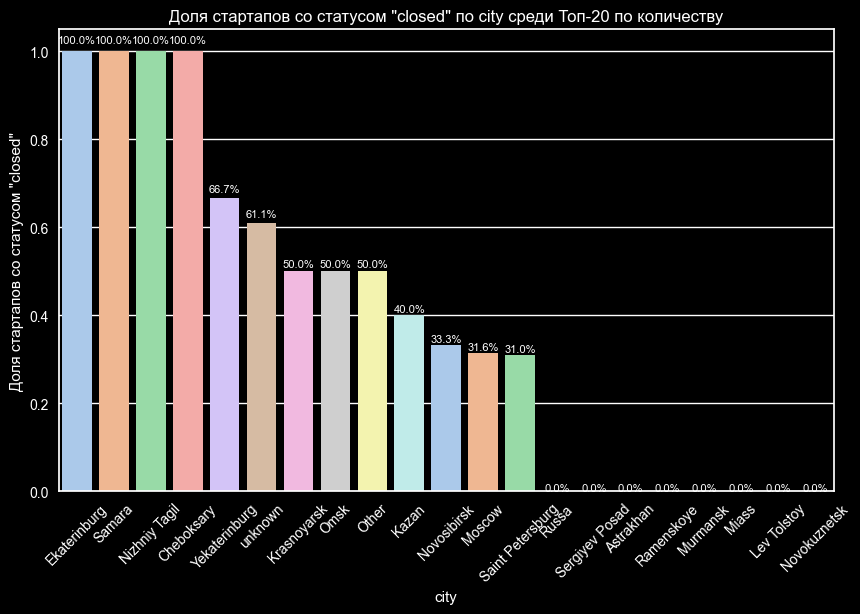

In [48]:
print('Расмотрим подробнее Россию')
for column in categorical_columns[1:]:
    plot_closed_ratio(df.query('country_code == "RUS"').copy(), column, top_n)

Печальная картина :)

##### Вывод

**Видно что этот признак так же очень важен для обучения**, но есть много значений которые встречаются 1 раз и не будут нести ценности при обучении, а так же очень много значений, которые встречаются 5 раз или реже. Планирую добавить фильтрацию редких значений в OHE при предобработке, это позволит значительно ускорить процесс обучений, предсказания и оптимизации модели.

- Среди топ-20 стран Россия является топ 1 по количеству закрытых стартапов, с общей долей 35.4%
- В США открывалось больше всего стартапов.
- Неизвестные значения так же имеют высокую долю неудачных проектов - 20-24%

### Признаки с датами

### Другие признаки

In [49]:
date_features = ['founded_at', 'first_funding_at', 'last_funding_at']

for feature in date_features:
    df[f'{feature}_year'] = df[feature].dt.year
    df[f'{feature}_month'] = df[feature].dt.month
    df[f'{feature}_day_of_week'] = df[feature].dt.dayofweek
    df[f'{feature}_week_of_year'] = df[feature].dt.isocalendar().week
    df[f'{feature}_day_of_year'] = df[feature].dt.dayofyear
    df[f'{feature}_day_of_month'] = df[feature].dt.day

# Предобработка

## Пропуски

In [50]:
missing_values = df.isnull().sum()
print("Пропущенные значения по признакам:")
missing_values[missing_values > 0]

Пропущенные значения по признакам:


name                                 1
funding_total_usd                10126
first_funding_at                    21
closed_at                        47917
first_funding_at_year               21
first_funding_at_month              21
first_funding_at_day_of_week        21
first_funding_at_week_of_year       21
first_funding_at_day_of_year        21
first_funding_at_day_of_month       21
dtype: int64

In [51]:
df.loc[df.funding_total_usd.isna() == True, df.columns[:13]]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaT
10,Indie Vinos,Software,NaN,operating,USA,OR,"Portland, Oregon",Portland,1,2009-01-01,2013-04-21,2013-04-21,NaT
16,Salesjob,unknown,NaN,closed,unknown,unknown,unknown,unknown,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
24,Savasti,unknown,NaN,closed,unknown,unknown,unknown,unknown,1,2015-01-01,2015-01-01,2015-01-01,2016-03-19
25,Brightree,Software,NaN,operating,USA,GA,Atlanta,Lawrenceville,1,2007-09-13,2008-07-15,2008-07-15,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52862,StockRadar,Finance|FinTech,NaN,operating,CHN,22,Beijing,Beijing,3,2011-01-01,2011-12-01,2015-09-22,NaT
52865,Zura!,E-Commerce,NaN,operating,BRA,27,BRA - Other,Brasil,1,2006-06-03,2008-01-01,2008-01-01,NaT
52870,Proactive Comfort,Medical,NaN,operating,USA,MD,Baltimore,Centreville,1,2009-10-16,2011-01-20,2011-01-20,NaT
52871,ScramCard,unknown,NaN,operating,HKG,unknown,Hong Kong,Hong Kong,1,2013-01-01,2015-11-20,2015-11-20,NaT


Пропуски будем обрабатывать в pipline, заменяя их на фиксированные значения.

# Обучение модели

Задаю random_state для возможности повторного эксперемента.

In [52]:
S = 100500

## Обучение и выбор модели на кросс-валидации при помощи Pycaret.

In [53]:
categorical_features = ['category_list','country_code','state_code', 'region', 'city']
ignore_features = ['name','closed_at']+date_features

In [54]:
experement = setup(df,target = target,train_size = 0.8,fold=5,categorical_imputation = 'unknown',
                   numeric_imputation = -1, rare_to_value = 0.0002,
                   session_id=S,categorical_features = categorical_features,
                   ignore_features=ignore_features,max_encoding_ohe=2000,fix_imbalance=True)

Exception in thread Thread-15 (_readerthread):
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\ProgramData\anaconda3\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xaf in position 6: invalid start byte
  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


,Description,Value
0,Session id,100500
1,Target,status
2,Target type,Binary
3,Target mapping,"closed: 0, operating: 1"
4,Original data shape,"(52879, 31)"
5,Transformed data shape,"(87242, 1337)"
6,Transformed train set shape,"(76666, 1337)"
7,Transformed test set shape,"(10576, 1337)"
8,Ignore features,5
9,Numeric features,20


In [55]:
%%time
%%chime

best_model = experement.compare_models(sort='f1',exclude=['gbc','dummy','nb','svm','lr','lda','qda'])

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:28:05
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9067,0.0000,0.9067,0.8753,0.8738,0.1098,0.1711,35.8560
et,Extra Trees Classifier,0.9035,0.0000,0.9035,0.8676,0.8735,0.1176,0.1613,25.6360
rf,Random Forest Classifier,0.9046,0.0000,0.9046,0.8689,0.8728,0.1075,0.1568,18.1540
ada,Ada Boost Classifier,0.8823,0.0000,0.8823,0.8614,0.8704,0.1739,0.1792,25.4260
dt,Decision Tree Classifier,0.8569,0.0000,0.8569,0.8503,0.8535,0.1192,0.1194,15.5520
ridge,Ridge Classifier,0.7546,0.0000,0.7546,0.8683,0.7983,0.1650,0.1930,13.5120
knn,K Neighbors Classifier,0.6598,0.0000,0.6598,0.8365,0.7281,0.0233,0.0300,22.2200


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

CPU times: total: 14min 15s
Wall time: 16min 16s
